### TEXT PREPROCESSING

In [4]:
import nltk
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from ast import literal_eval
import re, string
import pandas as pd


txt = open('dataset.txt')
raw = txt.read()

def preprocess_word(w):
    # Removes punctuation
    translator = str.maketrans('', '', string.punctuation)
    punctuation = w.translate(translator)

    return punctuation


def preprocessing(x):
    # Returns a nested list of the processed sentences
    
    mentions = re.sub(r'@\w+',"", x) #removes mentions
    numbers = re.sub('[0-9]+', "", mentions) #removes numbers
    links = re.sub(r'http\S+', "", numbers) #removes links
    
    sentence_tokenized = sent_tokenize(links) #sentence tokenization - INACCURATE!!!
    
    lower = [[sent.lower()] for sent in sentence_tokenized] #lower text
     
    in_list = [word for sent in lower for word in sent]

    word_tokenized = [word_tokenize(sent) for sent in in_list]
    word_tokenized = [sent for sent in word_tokenized if sent] #word tokenization
    
    for _id, sent in enumerate(word_tokenized):
        word_tokenized[_id] =  [preprocess_word(w) for w in sent]
    
    words = [[word for word in sent if word != '' and word != 'rt'] for sent in word_tokenized] #removes useless words
    sentences = [sent for sent in words if sent] #removes empty sentences
    
    
    return sentences

text = preprocessing(raw)
print(text)

dataframe =  pd.read_csv("dataset.txt")
print (dataframe.columns)

[['count', 'hatespeech', 'offensivelanguage', 'neither', 'class', 'tweet'], ['as', 'a', 'woman', 'you', 'should', 'nt', 'complain', 'about', 'cleaning', 'up', 'your', 'house'], ['amp', 'as', 'a', 'man', 'you', 'should', 'always', 'take', 'the', 'trash', 'out'], ['boy', 'dats', 'cold', 'tyga', 'dwn', 'bad', 'for', 'cuffin', 'dat', 'hoe', 'in', 'the', 'st', 'place'], ['dawg'], ['you', 'ever', 'fuck', 'a', 'bitch', 'and', 'she', 'start', 'to', 'cry'], ['you', 'be', 'confused', 'as', 'shit'], ['she', 'look', 'like', 'a', 'tranny'], ['the', 'shit', 'you', 'hear', 'about', 'me', 'might', 'be', 'true', 'or', 'it', 'might', 'be', 'faker', 'than', 'the', 'bitch', 'who', 'told', 'it', 'to', 'ya'], ['the', 'shit', 'just', 'blows', 'me', 'claim', 'you', 'so', 'faithful', 'and', 'down', 'for', 'somebody', 'but', 'still', 'fucking', 'with', 'hoes'], ['i', 'can', 'not', 'just', 'sit', 'up', 'and', 'hate', 'on', 'another', 'bitch'], ['i', 'got', 'too', 'much', 'shit', 'going', 'on'], ['cause', 'i', 'm

### BAG OF WORDS 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from ast import literal_eval

try: 
    assert(literal_eval(str(text)) == text.copy())
except AssertionError:
    print('failed to convert')
    
final_str = ([" ".join(x) for x in text])
print(final_str)

count_vect = CountVectorizer()
bow = count_vect.fit_transform(final_str)
print(bow)
bow.shape

['count hatespeech offensivelanguage neither class tweet', 'as a woman you should nt complain about cleaning up your house', 'amp as a man you should always take the trash out', 'boy dats cold tyga dwn bad for cuffin dat hoe in the st place', 'dawg', 'you ever fuck a bitch and she start to cry', 'you be confused as shit', 'she look like a tranny', 'the shit you hear about me might be true or it might be faker than the bitch who told it to ya', 'the shit just blows me claim you so faithful and down for somebody but still fucking with hoes', 'i can not just sit up and hate on another bitch', 'i got too much shit going on', 'cause i m tired of you big bitches coming for us skinny girls', 'amp you might not get ya bitch back amp thats that hobbies include fighting mariam bitch keeks is a bitch she curves everyone lol i walked into a conversation like this', 'smh murda gang bitch its gang land so hoes that smoke are losers', 'yea go on ig bad bitches is the only thing that i like bitch get 

(18, 200)

### EMBEDDINGS 

In [3]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

model = Word2Vec(sentences=text, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

vector = model.wv['bitch'] #returns numpy vector of a word
sims = model.wv.most_similar('bitch', topn=10) #returns similar words

word_vectors = [model.wv[word] for word in text]
#print(word_vectors)
print(vector)

C:\Users\Angelina\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[-6.0011004e-04  3.5360959e-04  5.1630838e-03  9.0867849e-03
 -9.2541082e-03 -7.4018831e-03  6.5150117e-03  9.3529113e-03
 -5.2239369e-03 -3.8987652e-03  7.4320082e-03 -1.8380596e-03
 -4.4119931e-03  6.6161761e-03 -4.9052667e-03 -1.8960083e-03
  2.9579655e-03  6.8660197e-04 -8.3746416e-03 -9.8520508e-03
  7.1796491e-03  5.1039709e-03  6.9026980e-03  6.6669541e-04
  6.2193922e-03 -3.3439391e-03 -9.8731637e-04  5.5331159e-03
 -7.6209470e-03 -3.8952811e-03 -7.4169445e-03 -8.7098643e-04
  9.6232062e-03 -7.3703481e-03 -2.4836296e-03 -1.5313016e-03
  8.1775784e-03 -5.9862784e-03 -7.6315875e-05 -5.0485507e-03
 -9.5888022e-03  4.6638306e-03 -8.8778744e-03 -4.3226257e-03
 -1.1867231e-05 -2.8456392e-04 -7.7313026e-03  9.5404256e-03
  4.9718060e-03  9.3226098e-03 -8.0978768e-03  4.3388125e-03
 -3.9997073e-03  8.2160125e-04  8.4270481e-03 -4.2953133e-03
  4.5531229e-03 -6.8877018e-03 -3.7526637e-03  9.5285513e-03
 -1.6770374e-03  2.9254222e-04 -4.1432241e-03 -7.7262158e-03
 -1.7488992e-03  2.58881

In [4]:
from sklearn.decomposition import IncrementalPCA  
from sklearn.manifold import TSNE                 
import numpy as np                                  


def reduce_dimensions(model):
    num_dimensions = 2 


    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key) 

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(autosize=True)
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)

### SYNTAX

In [5]:
def flatten_list(x):
#Takes a nested list and converts it into a list of elements
#where every sublist is a new element

    new_list = [] 
    
    for sent in x:
        sentences = " ".join(sent)
        new_list.append(sentences)
    
    return new_list

new = flatten_list(text)

In [6]:
import spacy

def dependency_parsing(x):
# Returns a nested list of syntactic labels

    nlp = spacy.load("en_core_web_sm")
    dependencies = []
    for sent in x:
        doc = nlp(sent)
        new_list = [token.dep_ for token in doc]
        dependencies.append(new_list)
        
    return dependencies

dep = dependency_parsing(new)


 count hatespeech offensivelanguage neither class tweet as a woman you should nt complain about cleaning up your house amp as a man you should always take the trash out boy dats cold tyga dwn bad for cuffin dat hoe in the st place dawg you ever fuck a bitch and she start to cry you be confused as shit she look like a tranny the shit you hear about me might be true or it might be faker than the bitch who told it to ya the shit just blows me claim you so faithful and down for somebody but still fucking with hoes i can not just sit up and hate on another bitch i got too much shit going on cause i m tired of you big bitches coming for us skinny girls amp you might not get ya bitch back amp thats that hobbies include fighting mariam bitch keeks is a bitch she curves everyone lol i walked into a conversation like this smh murda gang bitch its gang land so hoes that smoke are losers yea go on ig bad bitches is the only thing that i like bitch get up off me bitch nigga miss me with it bitch p

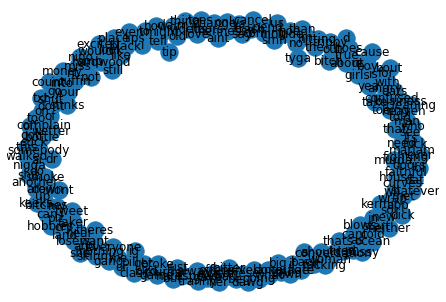

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import string
import pprint
%matplotlib inline

wordset = set()
for sentence in text:
    for word in sentence:
        wordset.add(word)

nlp = spacy.load("en_core_web_sm")

#Add every word as a node
base_graph = nx.Graph()
base_graph.add_nodes_from(wordset)
nx.draw(base_graph, with_labels=True)

graphs = {}
for sentence_id, sentence_contents in enumerate(new):
    sentence_graph = base_graph.copy()
    processed_sentence =  nlp(' '.join(new))
print('\n',processed_sentence)

In [8]:
#Add edges between the nodes according to syntactic relations
for token in processed_sentence:
    nodeA = token.text
    nodeB = token.head.text
    print('\tadding edge between', nodeA, 'and', nodeB)
    sentence_graph.add_edge(nodeA, nodeB)
    sentence_representation =  nx.adjacency_matrix(sentence_graph) #sparse matrix
    print('\t sparse matrix has ',sentence_representation.count_nonzero(),'nonzero elements')
    graphs[sentence_id] = sentence_representation

	adding edge between count and hatespeech
	 sparse matrix has  2 nonzero elements
	adding edge between hatespeech and offensivelanguage
	 sparse matrix has  4 nonzero elements
	adding edge between offensivelanguage and is
	 sparse matrix has  6 nonzero elements
	adding edge between neither and tweet
	 sparse matrix has  8 nonzero elements
	adding edge between class and tweet
	 sparse matrix has  10 nonzero elements
	adding edge between tweet and offensivelanguage
	 sparse matrix has  12 nonzero elements
	adding edge between as and tweet
	 sparse matrix has  14 nonzero elements
	adding edge between a and woman
	 sparse matrix has  16 nonzero elements
	adding edge between woman and as
	 sparse matrix has  18 nonzero elements
	adding edge between you and complain
	 sparse matrix has  20 nonzero elements
	adding edge between should and complain
	 sparse matrix has  22 nonzero elements
	adding edge between nt and complain
	 sparse matrix has  24 nonzero elements
	adding edge between complai

	 sparse matrix has  211 nonzero elements
	adding edge between sit and told
	 sparse matrix has  213 nonzero elements
	adding edge between up and sit
	 sparse matrix has  215 nonzero elements
	adding edge between and and sit
	 sparse matrix has  217 nonzero elements
	adding edge between hate and sit
	 sparse matrix has  219 nonzero elements
	adding edge between on and hate
	 sparse matrix has  221 nonzero elements
	adding edge between another and bitch
	 sparse matrix has  223 nonzero elements
	adding edge between bitch and on
	 sparse matrix has  225 nonzero elements
	adding edge between i and got
	 sparse matrix has  227 nonzero elements
	adding edge between got and bitch
	 sparse matrix has  229 nonzero elements
	adding edge between too and much
	 sparse matrix has  231 nonzero elements
	adding edge between much and shit
	 sparse matrix has  233 nonzero elements
	adding edge between shit and got
	 sparse matrix has  235 nonzero elements
	adding edge between going and got
	 sparse ma

	 sparse matrix has  428 nonzero elements
	adding edge between me and tell
	 sparse matrix has  430 nonzero elements
	adding edge between nothing and cancel
	 sparse matrix has  432 nonzero elements
	adding edge between cancel and tell
	 sparse matrix has  434 nonzero elements
	adding edge between that and bitch
	 sparse matrix has  436 nonzero elements
	adding edge between bitch and cancel
	 sparse matrix has  438 nonzero elements
	adding edge between like and bitch
	 sparse matrix has  438 nonzero elements
	adding edge between nino and like
	 sparse matrix has  440 nonzero elements
	adding edge between ca and see
	 sparse matrix has  442 nonzero elements
	adding edge between nt and see
	 sparse matrix has  444 nonzero elements
	adding edge between you and see
	 sparse matrix has  446 nonzero elements
	adding edge between see and tell
	 sparse matrix has  448 nonzero elements
	adding edge between these and hoes
	 sparse matrix has  450 nonzero elements
	adding edge between hoes and ch

	 sparse matrix has  632 nonzero elements
	adding edge between bitches and get
	 sparse matrix has  634 nonzero elements
	adding edge between would and get
	 sparse matrix has  636 nonzero elements
	adding edge between get and is
	 sparse matrix has  638 nonzero elements
	adding edge between excited and get
	 sparse matrix has  640 nonzero elements
	adding edge between if and ai
	 sparse matrix has  642 nonzero elements
	adding edge between you and ai
	 sparse matrix has  644 nonzero elements
	adding edge between ai and get
	 sparse matrix has  646 nonzero elements
	adding edge between nt and ai
	 sparse matrix has  648 nonzero elements
	adding edge between bout and ai
	 sparse matrix has  650 nonzero elements
	adding edge between that and shut
	 sparse matrix has  652 nonzero elements
	adding edge between murder and game
	 sparse matrix has  654 nonzero elements
	adding edge between game and pussy
	 sparse matrix has  656 nonzero elements
	adding edge between pussy and nigga
	 sparse 

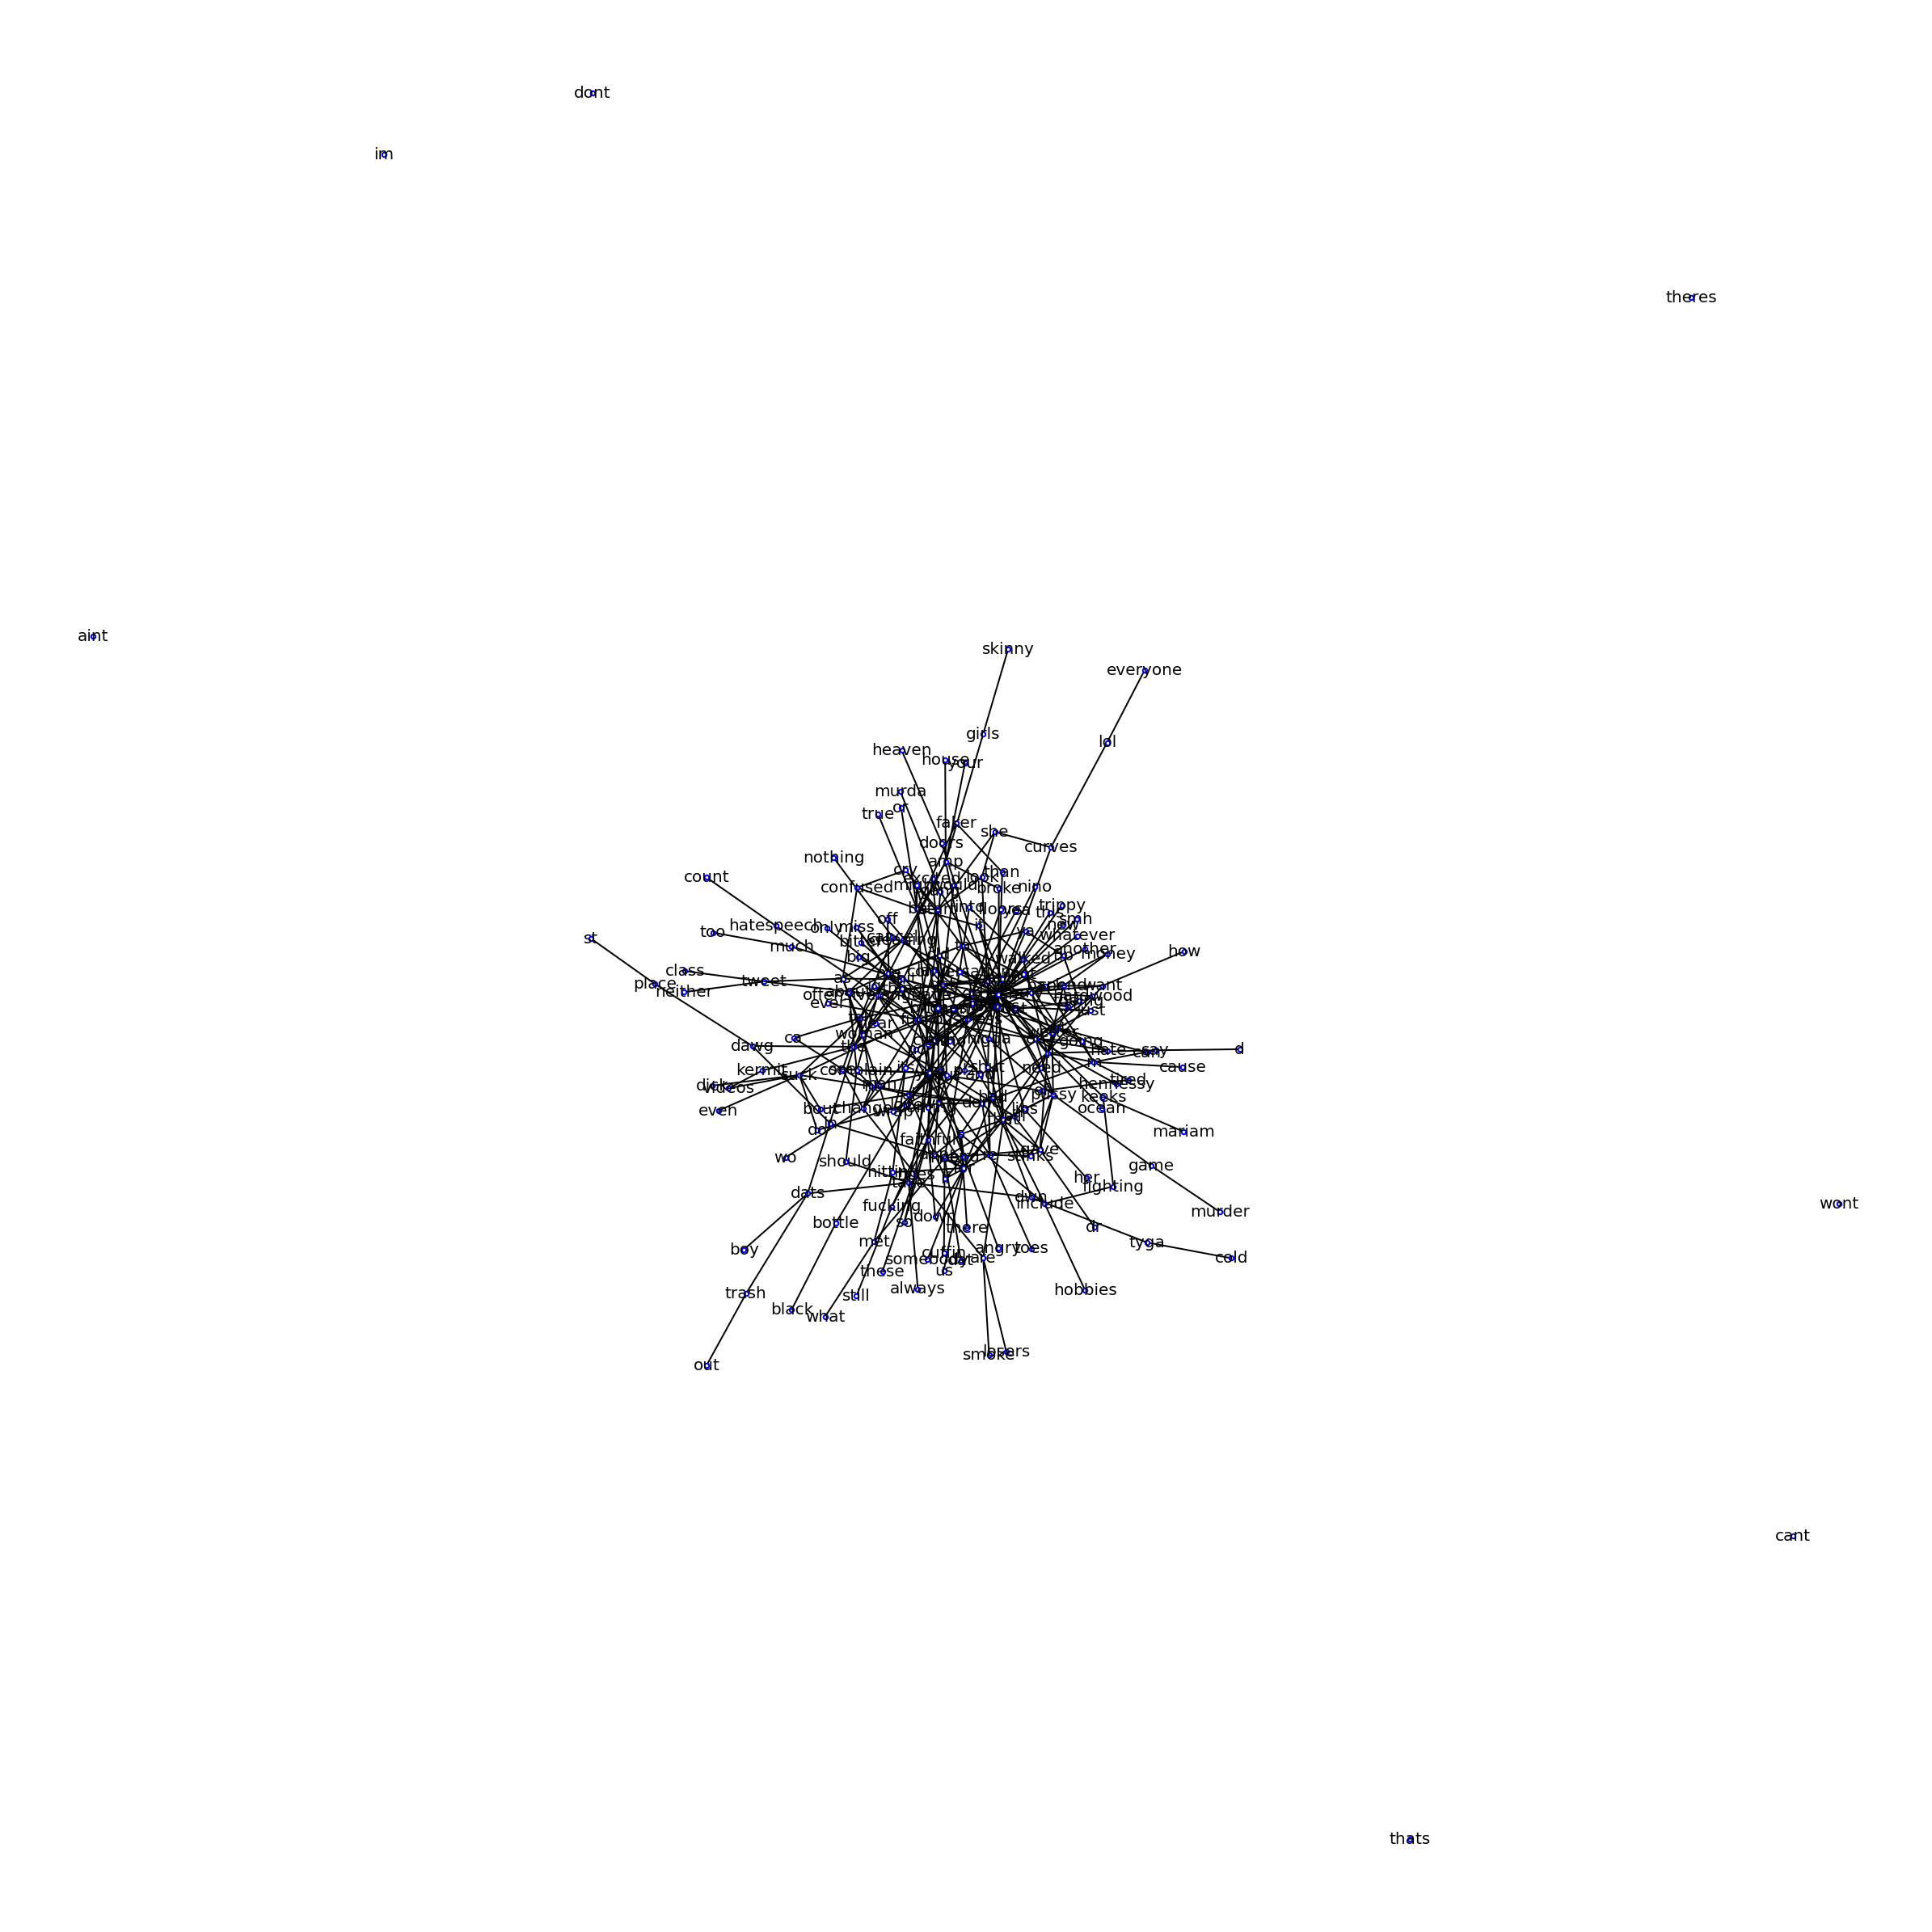

In [9]:
options = {
    "font_size": 20,
    "node_size": 30,
    "node_color": "white",
    "edgecolors": 'blue',
    "linewidths": 2,
    "width": 2,
}
plt.figure(3,figsize=(33,33)) 
nx.draw(sentence_graph, with_labels=True, **options)

In [10]:
print(sentence_representation)

  (0, 58)	1
  (0, 102)	1
  (0, 111)	1
  (0, 204)	1
  (1, 41)	1
  (1, 72)	1
  (1, 108)	1
  (2, 88)	1
  (3, 18)	1
  (3, 48)	1
  (3, 172)	1
  (3, 201)	1
  (4, 7)	1
  (5, 27)	1
  (5, 167)	1
  (5, 174)	1
  (6, 53)	1
  (6, 114)	1
  (6, 178)	1
  (6, 198)	1
  (7, 4)	1
  (7, 104)	1
  (7, 154)	1
  (7, 167)	1
  (7, 204)	1
  :	:
  (201, 182)	1
  (201, 183)	1
  (201, 187)	1
  (201, 189)	1
  (201, 199)	1
  (202, 73)	1
  (202, 83)	1
  (202, 89)	1
  (202, 121)	1
  (202, 124)	1
  (202, 181)	1
  (202, 202)	1
  (203, 171)	1
  (204, 0)	1
  (204, 7)	1
  (204, 17)	1
  (204, 58)	1
  (204, 110)	1
  (204, 136)	1
  (204, 192)	1
  (204, 207)	1
  (205, 71)	1
  (205, 128)	1
  (206, 83)	1
  (207, 204)	1


In [11]:
print('\n\nsaving representations...')
import pickle
with open('sentence_representations_adjmat.p','wb') as fw:
    pickle.dump(graphs, fw)



saving representations...


### CLASSIFICATION

In [12]:
import numpy as np

feats = np.concatenate([word_vectors,bow],axis=0)

<__array_function__ internals>:5: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

dataframe =  pd.read_csv("dataset.txt")
#flatten_list(word_vectors)

X = pd.DataFrame(bow)
y = dataframe['class'].astype(int)
bow.shape
#y.shape

(18, 200)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [18, 35]

In [ ]:
y_pred = classifier.predict(X_test)